In [1]:
!make -C .. agglom_extent

make: Entering directory '/home/martibosch/data-science/lausanne-agglom-extent'
make: Nothing to be done for 'agglom_extent'.
make: Leaving directory '/home/martibosch/data-science/lausanne-agglom-extent'


In [2]:
import contextily as ctx
import geopandas as gpd

In [3]:
WEB_MERCATOR_CRS = 'epsg:3857'

In [4]:
agglom_extent_filepath = '../data/processed/agglom-extent.shp'

The obtained shapefile consists of two polygons, i.e., the agglomeration extent and a mask for the lake. For this plot, we will only include the former.

In [5]:
agglom_extent_gdf = gpd.read_file(agglom_extent_filepath).to_crs(
    WEB_MERCATOR_CRS).iloc[:1]

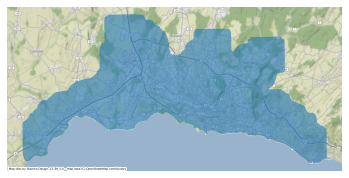

In [6]:
ax = agglom_extent_gdf.plot(alpha=.6)
ctx.add_basemap(ax, attribution_size=2.8)
ax.set_axis_off()
ax.get_figure().savefig('../reports/figures/agglom-extent.png',
                        dpi=200,
                        bbox_inches='tight',
                        pad_inches=0)